In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [18]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
# Data Loading and Preprocessing 
def load_and_preprocess_data(filepath):
    # Load the dataset
    df = pd.read_csv(filepath)

    # Separate features and target
    X = df.drop('stroke', axis=1)
    y = df['stroke']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler



In [20]:
# Create ANN Model
def create_ann_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [21]:
# Custom Callback to Track Epoch Training Time
class EpochTimeCallback(Callback):
    def __init__(self):
        super().__init__()
        self.epoch_times = []
        self.epoch_start_time = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_end_time = time.time()
        self.epoch_times.append(epoch_end_time - self.epoch_start_time)

In [25]:
# Training Function
def train_model(X_train, y_train):
    # Create model
    model = create_ann_model(X_train.shape[1])

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Epoch time tracking callback
    epoch_time_callback = EpochTimeCallback()

    # Train the model with tqdm
    epochs = 50
    progress_bar = tqdm(range(epochs), desc="Training Progress", unit="epoch")

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=32,
        callbacks=[
            early_stopping,
            epoch_time_callback,
            tf.keras.callbacks.LambdaCallback(
                on_epoch_end=lambda epoch, logs: progress_bar.set_postfix(
                    loss=f"{logs.get('loss'):.4f}",
                    val_loss=f"{logs.get('val_loss'):.4f}"
                )
            )
        ],
        verbose=0
    )

    return model, history, epoch_time_callback


In [26]:
# Evaluation Function
def evaluate_model(model, X_test, y_test, history, epoch_time_callback):
    # Start overall timing
    start_time = time.time()

    # Predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate total training time
    total_training_time = time.time() - start_time

    # Performance Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Detailed Classification Report
    class_report = classification_report(y_test, y_pred)

    # Visualizations
    plt.figure(figsize=(20, 5))

    # 1. Loss Curves
    plt.subplot(141)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Accuracy Curves
    plt.subplot(142)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 3. Confusion Matrix
    plt.subplot(143)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # 4. Epoch Training Time
    plt.subplot(144)
    plt.plot(epoch_time_callback.epoch_times, color='green')
    plt.title('Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')

    plt.tight_layout()
    plt.show()

    # Save performance metrics
    performance_metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Total Training Time (s)': total_training_time,
        'Average Epoch Time (s)': np.mean(epoch_time_callback.epoch_times),
        'Classification Report': class_report,
        'Epoch Times': epoch_time_callback.epoch_times
    }

    return performance_metrics


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

Training Progress:   0%|          | 0/50 [00:26<?, ?epoch/s, loss=0.1872, val_loss=0.2201]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


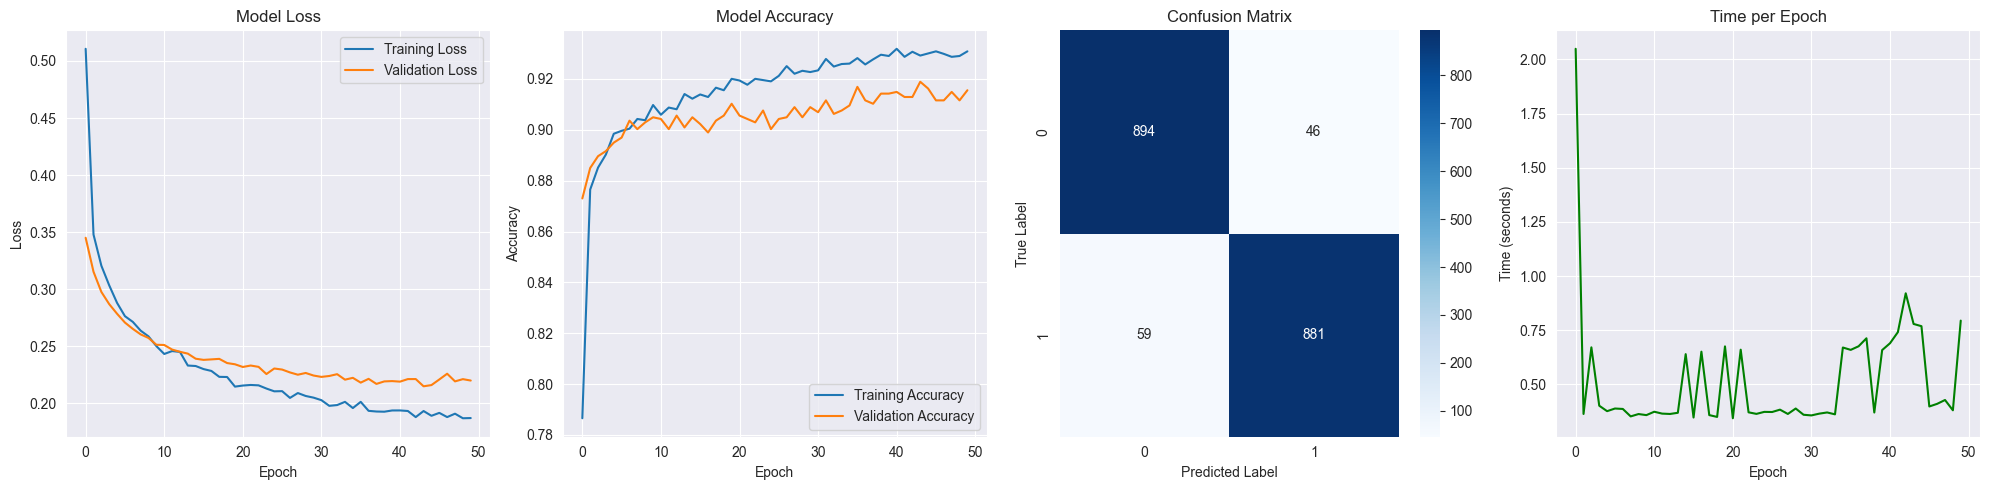

Accuracy: 0.9441489361702128
Precision: 0.9503775620280475
Recall: 0.9372340425531915
F1 Score: 0.9437600428494911
Total Training Time (s): 0.6045799255371094
Average Epoch Time (s): 0.5138119077682495
Classification Report:               precision    recall  f1-score   support

           0       0.94      0.95      0.94       940
           1       0.95      0.94      0.94       940

    accuracy                           0.94      1880
   macro avg       0.94      0.94      0.94      1880
weighted avg       0.94      0.94      0.94      1880

Epoch Times: [2.0490336418151855, 0.3634302616119385, 0.6708886623382568, 0.4015169143676758, 0.3762807846069336, 0.38855576515197754, 0.38657450675964355, 0.35216212272644043, 0.36304211616516113, 0.35810422897338867, 0.37375664710998535, 0.36504197120666504, 0.3633999824523926, 0.3688509464263916, 0.6395535469055176, 0.3469889163970947, 0.650942325592041, 0.35816407203674316, 0.3498106002807617, 0.6753458976745605, 0.34363818168640137, 0.6601

In [27]:
# Main Execution
def main():
    filepath = r"C:\Users\HP\Documents\GitHub\ci-coursework\cleaned-stroke-prediction-dataset-balanced.csv"

    # Load and Preprocess Data
    X_train, X_test, y_train, y_test, scaler = load_and_preprocess_data(filepath)

    # Train Model
    model, history, epoch_time_callback = train_model(X_train, y_train)

    # Evaluate Model
    performance_metrics = evaluate_model(model, X_test, y_test, history, epoch_time_callback)

    # Print Performance Metrics
    for metric, value in performance_metrics.items():
        print(f"{metric}: {value}")


# Run the script
if __name__ == "__main__":
    main()